## Data preprocessing:
'getData' function return the properties of the simulations as x, and corresponding stellar system labels as y.
* $y = (212, 1)$ (now just a single multiplicity label for each sink particle, NOT always multiplicity in final snapshot)
* $x = (212,$ `num_samples` $\times 14)$ (gas properties sampled at `num_samples` points in simulation prior to sink particle formation)

Gas properties then go through preprocessing step: Yeo-Johnson transformation is used to remove skewness and normalized the data $(\mu = 0, \sigma = 1)$.

## Simple K-mean clustering

Simple kmeans is applied to the transformed data.
* PCA is used to reduced the dimension of data to visualize the result

## Spectral Clustering and Dimension reducing using t-SNE
* The Spectral Clustering with radial bias function kernel is applied to the dataset.
* Use t-SNE as dimension reduction method instead of PCA to see nonlinear relation of the dataset

In [2]:
import numpy as np
import sys
import os
import h5py
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

datadir = '../data'
figdir  = '../data'

fname_data = os.path.join(datadir, 'gas_data.hdf5')   

# UPDATED DATA TO BE USED:
# datasets in fname_data: 
#  - data_1point (sample all 14 gas properties at t_formation) (212x14)
#  - data_5point (sample gas properties at 5 times between start of simulation and t_formation) (212x5*14)
#  - data_10point (sample at 10 different times) (212x10*14)
#  - data_20_point (212x20*14)
#  - data_30_point
#  - data_50_point
#  - sink_IDs (212x1)
#  - labels (multiplicity shortly after formation time, before dynamical ejections from stellar systems) (212x1)
#  - labels_final (multiplicity at the end of the simulation)

# Return the labels, gas properties (sampled at 1 up to 50 times in simulation), and sink_IDs.
def loadData(fname_data):
    with h5py.File(fname_data, 'r') as f:
        sink_IDs     = f['sink_IDs'][()]      # (212,)
        labels       = f['labels'][()]        # (212,)
        labels_final = f['labels_final'][()]  # (212,)
        data_1point  = f['data_1point'][()]   # (212, 1x14)
        data_5point  = f['data_5point'][()]   # (212, 5x14)
        data_10point = f['data_10point'][()]  # (212, 10x14)
        data_20point = f['data_20point'][()]  # (212, 20x14)
        data_30point = f['data_30point'][()]  # (212, 30x14)
        data_50point = f['data_50point'][()]  # (212, 50x14)
        
        data = [data_1point, data_5point, data_10point, data_20point, data_30point, data_50point]
        
        # Replace NaN with 0
        for dset in data:
            dset[np.isnan(dset)] = 0.0
            
        # Replace inf with 0 for now.
        for dset in data:
            dset[np.isinf(dset)] = 0.0
            
        n_sinks = len(sink_IDs)
        
    labels       = np.reshape(labels, (n_sinks, 1))
    labels_final = np.reshape(labels_final, (n_sinks, 1))
        
    return labels, labels_final, data, sink_IDs


# Add option to replace labels ['2', '3', '4'] with just '2' to compare single vs. multiple systems.
def getData(fname_data, num_samples='20', use_labels='initial', relabel_multiplicity=False):
    '''
    num_samples = '1', '5', '10', '20', '30', '50'
    use_labels = 'initial' to use labels, 'final' to use labels_final
    '''
    labels_initial, labels_final, data, sink_IDs = loadData(fname_data)
    
    # Decide which multiplicity labels to use (at formation vs. end of simulation).
    if use_labels == 'initial':
        labels = labels_initial
    else:
        labels = labels_final
    
    # Replace higher-order multiplicity labels with '2'.
    if relabel_multiplicity:
        labels[(labels >= 2)] = 2
    
    y = labels
    if num_samples == '1':
        x = data[0]
    elif num_samples =='5':
        x = data[1]
    elif num_samples == '10':
        x = data[2]
    elif num_samples == '20':
        x = data[3]
    elif num_samples == '30':
        x = data[4]
    else:
        x = data[5]
    return x, y

def runKMeans(x, y, n_clusters, make_fig=True, transform = True):
    # Pre-process data.
    if transform == True:
        pt      = PowerTransformer(method= 'yeo-johnson', standardize= True)
        x_trans = pt.fit_transform(x)
    else:
        scalar = StandardScaler()
        x_trans = scalar.fit_transform(x)
    # Run kmeans.
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='lloyd')
    kmeans.fit(x_trans)
    # Use PCA to reduce the dimensions to first 2 singular vectors.
    pca = PCA(n_components=2)
    pca.fit(x_trans)
    reducedX = pca.transform(x_trans)
    reducedCluster_center = pca.transform(kmeans.cluster_centers_)
    # Plot the data in the reduced dimensions.
    if make_fig:
        fig, ax = plt.subplots(1, 2, layout = 'tight', figsize=[10, 5])
        color = ['g', 'b', 'k', 'y']
        label = ['1', '2', '3', '4']
        for i in range(0, reducedX.shape[0]):
            ax[0].scatter(reducedX[i, 0], reducedX[i, 1], c = color[np.int32(y[i, 0])-1])
            ax[1].scatter(reducedX[i, 0], reducedX[i, 1], c = color[kmeans.labels_[i]])
            ax[1].scatter(reducedCluster_center[:, 0], reducedCluster_center[:, 1], c='r', marker = 'X', s=150)
            ax[0].set_title('Reduced data with label')
            ax[1].set_title('Clustering result')
        plt.show()
    return kmeans.labels_, kmeans.cluster_centers_, kmeans.inertia_

In [8]:
x, y = getData(fname_data, num_samples='20', use_labels='final', relabel_multiplicity=False)

In [9]:
pt      = PowerTransformer(method= 'yeo-johnson', standardize= True)
x_trans = pt.fit_transform(x)

1.1145822746209133
3.3301483975073825
-1.131170628863367e-16
1.0000000000000004


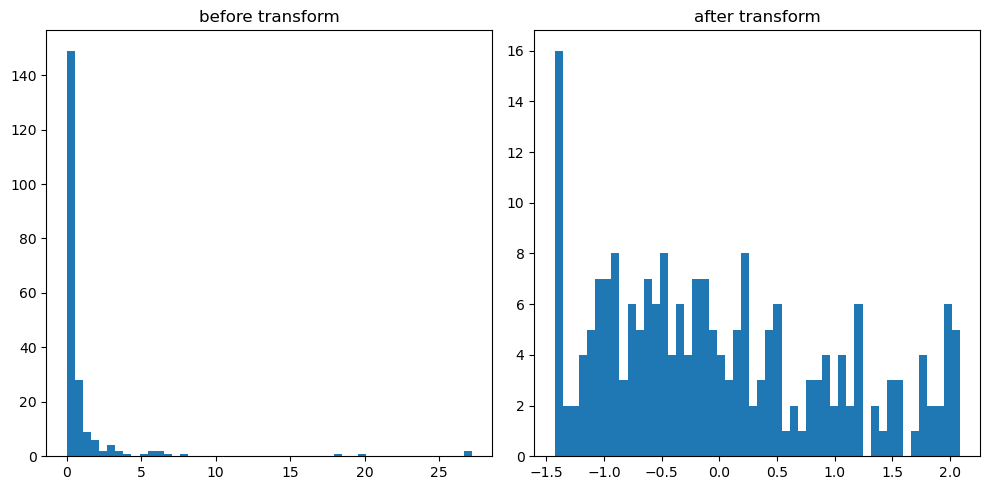

In [5]:
fig1,ax1 = plt.subplots(1, 2, layout = 'tight', figsize = [10, 5])
p = 0
ax1[0].hist(x[:, p], bins = 50)
ax1[0].set_title('before transform')
ax1[1].hist(x_trans[:, p], bins = 50)
ax1[1].set_title('after transform')
print(np.mean(x[:, p]))
print(np.std(x[:, p]))
print(np.mean(x_trans[:, p]))
print(np.std(x_trans[:, p]))

Number of snapshots used = 1


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


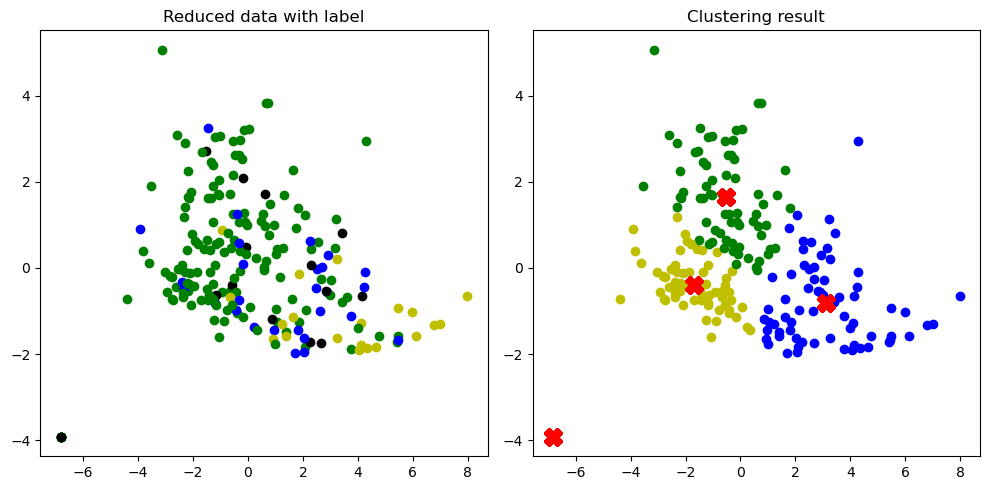

Number of snapshots used = 5


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


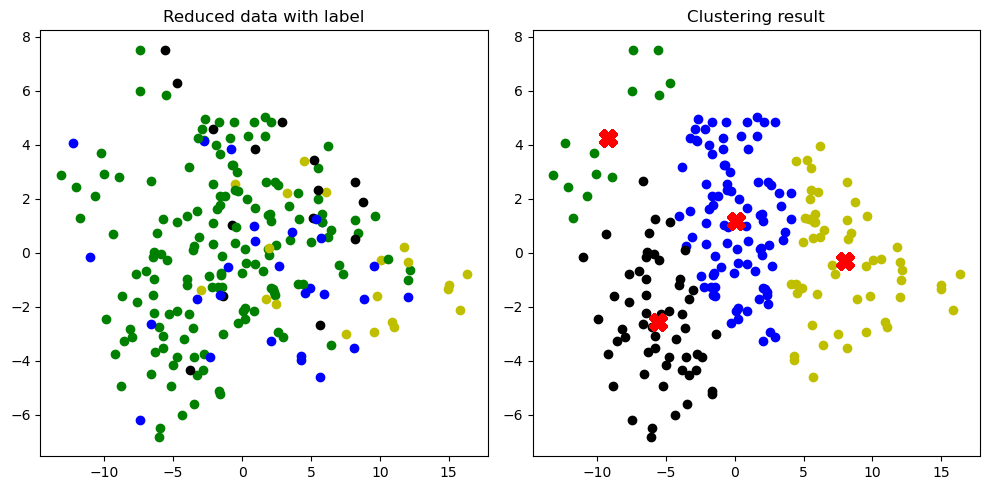

Number of snapshots used = 10


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


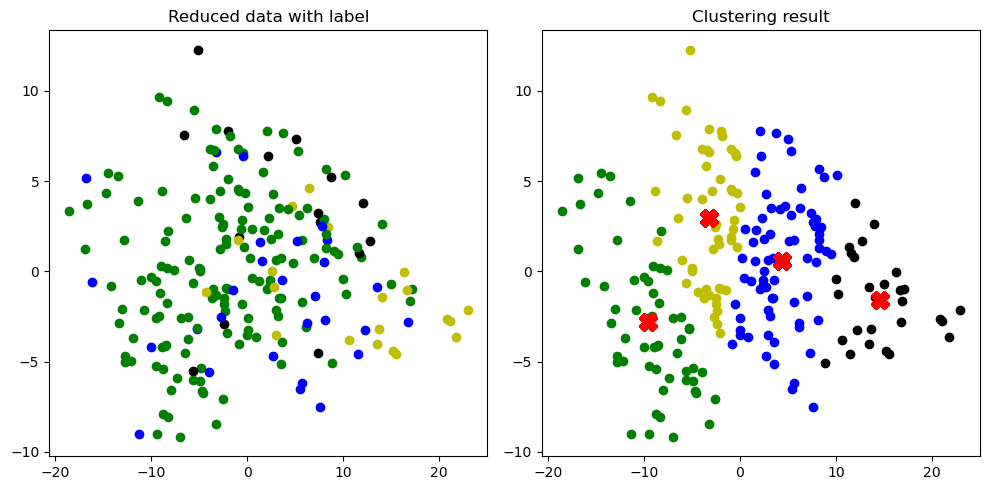

Number of snapshots used = 20


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


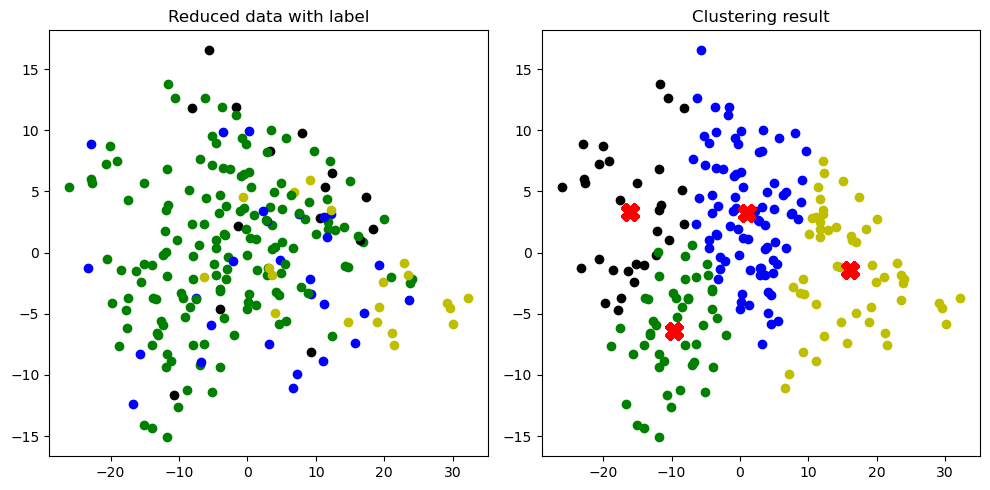

Number of snapshots used = 30


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


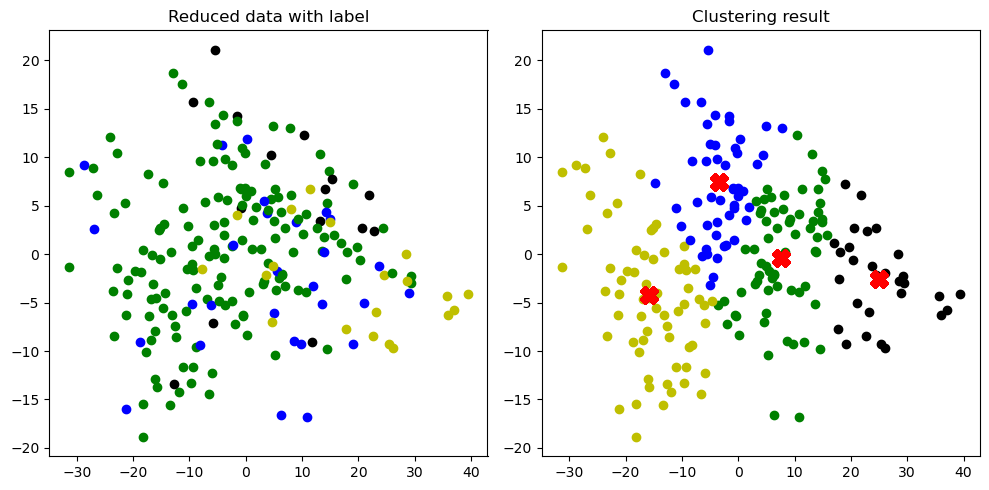

Number of snapshots used = 50


/Users/albertzhang/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


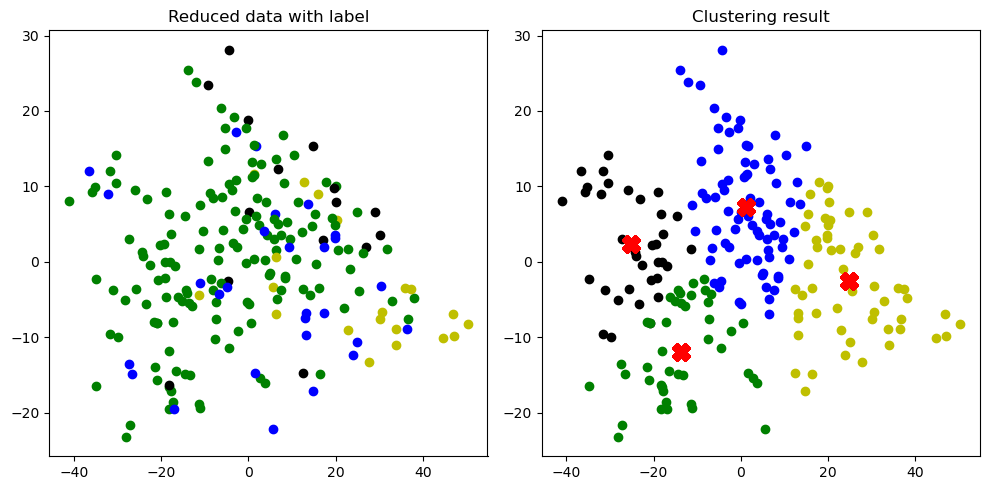

In [11]:
# Use labels_initial, don't relabel higher-order multiplicity. n_clusters = 4
for num_samples in ['1', '5', '10', '20', '30', '50']:
    print('Number of snapshots used = {0:s}'.format(num_samples))
    x, y = getData(fname_data, num_samples=num_samples, use_labels='final', relabel_multiplicity=False)
    labels, centers, inertia = runKMeans(x, y, 4, make_fig=True, transform=True)

In [ ]:
# Use labels_initial, do relabel higher-order multiplicity. n_clusters = 2
for num_samples in ['1', '5', '10', '20', '30', '50']:
    print('Number of snapshots used = {0:s}'.format(num_samples))
    x, y = getData(fname_data, num_samples=num_samples, use_labels='initial', relabel_multiplicity=True)
    labels, centers, inertia = runKMeans(x, y, 2, make_fig=True)

In [ ]:
spCluster = SpectralClustering(n_clusters = 4, affinity='rbf')
spCluster.fit(x_trans)
tSNE = TSNE(n_components=2, random_state=100)
reducedX_tsne= tSNE.fit_transform(x_trans)
fig3,ax3 = plt.subplots(1,2, layout = 'tight', figsize=[10, 5])

color = ['g', 'b', 'k', 'y']
label = ['1', '2', '3', '4']
# plot the data in the reduced dim
for i in range(0, reducedX.shape[0]):
    ax3[0].scatter(reducedX_tsne[i, 0], reducedX_tsne[i, 1], c = color[np.int32(y[i, 0])-1])
    ax3[1].scatter(reducedX_tsne[i, 0], reducedX_tsne[i, 1], c = color[spCluster.labels_[i]])

#ax3[1].scatter(reducedCluster_center[:, 0], reducedCluster_center[:, 1], c='r', marker = 'X', s=150)
ax3[0].set_title('Reduced data with label')
ax3[1].set_title('Clustering result')